# dots measurement at Subaru (20210710) (for all visits)

In [1]:
%matplotlib inline
import pandas as pd
import sep
import cv2
from copy import deepcopy

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [2]:
def rotatePoint2(coord, ori, angle):
    """Only rotate a point around the origin (0, 0)."""
    radians = np.deg2rad(angle)
    x = coord[0] - ori[0]
    y = coord[1] - ori[1]
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)
    
    return xx+ori[0], yy+ori[1]

## function for the dot measurement

In [3]:
def get_dot_position(data, rx, ry, angle, reg1, thresh1, reg2, thresh2):

    ## data region trimming (1st pass) ##
    reg=reg1
    v_med =  np.nanmedian(data)
    imag_new = np.zeros(data.shape) + v_med
    for xd, yd in zip(rx, ry):
        try:
            x1 = int(xd - reg)
            x2 = int(xd + reg)
            y1 = int(yd - reg)
            y2 = int(yd + reg)
            imag_new[y1:y2, x1:x2] = data[y1:y2, x1:x2]
        except:
            pass
    imag_new[imag_new > thresh1] = v_med

    ## get dot positions (1st pass) ##
    print(f'running 1st pass ...')
    reg=reg1
    bad_idx = []
    dot_pos = []
    for i in range(len(rx)):
        data_sub=imag_new[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
        imag_sub=deepcopy(data_sub)
        imag_sub = 255 * imag_sub / imag_sub.max()
        circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                                   param1=50,param2=8,minRadius=6,maxRadius=12)
        if circles is not None:
            dot_x = int(rx[i]-reg)+circles[0,0,0]
            dot_y = int(ry[i]-reg)+circles[0,0,1]
            dot_r = circles[0,0,2]
            dot_pos.append((dot_x, dot_y, dot_r))
        else:
            bad_idx.append(i)
            dot_pos.append((np.nan, np.nan, np.nan))
            print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
    dot_pos = np.array(dot_pos) 
    
    ## transformation (1st pass) ##
    pts0=np.zeros((1,len(fel),3))
    pts0[0,:,0]=fel['x_mm']
    pts0[0,:,1]=fel['y_mm']
    pts0[0,:,2]=[0 for x in fel['x_mm']]
    pts1=np.zeros((1,len(fel),3))
    pts2=np.zeros((1,len(fel),2))
    pts1[0,:,0]=fel['x_mm']
    pts1[0,:,1]=fel['y_mm']
    pts1[0,:,2]=[0 for x in fel['x_mm']]
    pts2[0,:,0]=dot_pos[:,0]
    pts2[0,:,1]=dot_pos[:,1]
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    for i in np.sort(bad_idx)[::-1]:
        pts1 = np.delete(pts1, i, 1)
        pts2 = np.delete(pts2, i, 1)    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)    
    for i in range(len(pts0)):
        imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
    dot_pos_new = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_pos[:,2])])
    
    ## data region trimming (2nd pass) ##
    rx2 = dot_pos_new[:,0]
    ry2 = dot_pos_new[:,1]   
    reg=reg2
    v_med =  np.nanmedian(data)
    imag_new2 = np.zeros(data.shape) + v_med
    for xd, yd in zip(rx2, ry2):
        try:
            x1 = int(xd - reg)
            x2 = int(xd + reg)
            y1 = int(yd - reg)
            y2 = int(yd + reg)
            imag_new2[y1:y2, x1:x2] = data[y1:y2, x1:x2]
        except:
            pass
    imag_new2[imag_new2 > thresh2] = v_med

    ## get dot positions (2nd pass) ##
    print(f'running 2nd pass ...')
    reg=reg2
    bad_idx = []
    dot_pos2 = []
    for i in range(len(rx2)):
        data_sub=imag_new2[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)]
        imag_sub=deepcopy(data_sub)
        imag_sub = 255 * imag_sub / imag_sub.max()
        circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 20,
                                   param1=50,param2=5,minRadius=8,maxRadius=12)
        if circles is not None:
            dot_x = int(rx2[i]-reg) + circles[0,0,0]
            dot_y = int(ry2[i]-reg) + circles[0,0,1]
            dot_r = circles[0,0,2]
            dot_pos2.append((dot_x, dot_y, dot_r))
        else:
            bad_idx.append(i)
            dot_pos2.append((np.nan, np.nan, np.nan))
            print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
    dot_pos2 = np.array(dot_pos2)    


    ## transformation (1st pass) ##
    pts0=np.zeros((1,len(fel),3))
    pts0[0,:,0]=fel['x_mm']
    pts0[0,:,1]=fel['y_mm']
    pts0[0,:,2]=[0 for x in fel['x_mm']]
    pts1=np.zeros((1,len(fel),3))
    pts2=np.zeros((1,len(fel),2))
    pts1[0,:,0]=fel['x_mm']
    pts1[0,:,1]=fel['y_mm']
    pts1[0,:,2]=[0 for x in fel['x_mm']]
    pts2[0,:,0]=dot_pos2[:,0]
    pts2[0,:,1]=dot_pos2[:,1]
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    for i in np.sort(bad_idx)[::-1]:
        pts1 = np.delete(pts1, i, 1)
        pts2 = np.delete(pts2, i, 1)    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)    
    ## calculate dot center ##
    for i in range(len(pts0)):
        imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
    ## calculate dot radius ##
    pts0d = deepcopy(pts0)
    pts0d[0,:,0] = pts0d[0,:,0] + 1.5 / np.cos(np.pi/180.*angle)
    for i in range(len(pts0)):
        tmp1, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
    for i in range(len(pts0d)):
        tmp2, _ = cv2.projectPoints(pts0d[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
    dot_rad = (tmp2[:,0,0] - tmp1[:,0,0]) / 2.0
    dot_pos_new2 = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])       
    return dot_pos2, dot_pos_new2

## get designed dots information

In [4]:
fel=pd.read_csv('/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/dot_pos_final.txt', sep = '\s+')
fel

,id,x_mm,y_mm,x,y,bb,cc
0,0,96.994843,0.0,5614.759176,2886.225955,5614.759277,2886.101562
1,1,103.923042,4.0,5695.685201,2932.765529,5695.393555,2932.880127
2,2,110.851250,8.0,5776.593112,2979.286068,5776.393066,2979.337891
3,3,117.779450,12.0,5857.156087,3025.757010,5857.078613,3025.395508
4,4,124.707657,16.0,5937.719843,3072.196818,5937.756348,3072.048340
...,...,...,...,...,...,...,...
2389,2389,-41.569214,80.0,3996.636351,3826.956730,3996.431152,3826.726807
2390,2390,-55.425613,88.0,3834.981196,3920.772418,3834.983154,3919.957031
2391,2391,-69.282028,96.0,3673.712751,4014.114572,3673.579834,4013.147461
2392,2392,-83.138428,104.0,3512.717930,4107.249548,3512.585449,4106.453613


## rot angle = 0 deg.

### transformation for initial guess (you need to do this carefully)

In [5]:
## very rough estimate ##
x_shift = 3838
y_shift = 3517
x_scale = 13.3
y_scale = 13.3
rot = 0.0
xx=(fel['x_mm'].values.astype(float)*x_scale)+x_shift
yy=(fel['y_mm'].values.astype(float)*y_scale)+y_shift
rx,ry=rotatePoint2([xx,yy],[x_shift,y_shift], rot)

In [6]:
id_sel = [1567, 2351, 783, 785]
x_mcs_sel = [5123, 2436, 7606, 5149]
y_mcs_sel = [6545, 2136, 2009, 3722]
x_pfi_sel = list(fel.loc[id_sel]['x_mm'])
y_pfi_sel = list(fel.loc[id_sel]['y_mm'])

pts1=np.zeros((1,len(id_sel),2))
pts2=np.zeros((1,len(id_sel),2))
pts1[0,:,0]=x_pfi_sel
pts1[0,:,1]=y_pfi_sel
pts2[0,:,0]=x_mcs_sel
pts2[0,:,1]=y_mcs_sel

afCoeff,inlier=cv2.estimateAffinePartial2D(pts1, pts2)
inlier=inlier.reshape(len(inlier))

M={}
M['affineCoeff'] = afCoeff
M['xTrans']=afCoeff[0,2]
M['yTrans']=afCoeff[1,2]
M['xScale']=np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2)
M['yScale']=np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2)
M['angle']=np.arctan2(afCoeff[1,0]/np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2), afCoeff[1,1]/np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2))

pts=np.zeros((1,len(fel),2))
pts[0,:,0]=fel['x_mm']
pts[0,:,1]=fel['y_mm']
afCor=cv2.transform(pts, M['affineCoeff'])
rx=afCor[0,:,0]
ry=afCor[0,:,1]

### dot positions measurement (t_ext = 0.5 sec.)

In [7]:
visits = [22589000, 22589100, 22589200, 22589300, 22589400]

res_dot_pos_meas = []
res_dot_pos_tran = []
for visit in visits:
    print('visit=%d' % (visit))
    ## get data ##
    filename='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC%d.fits' % (visit)
    f =pyfits.open(filename)
    data=f[1].data
    ## measurement ##
    dot_pos2, dot_pos_new2 = get_dot_position(data, rx, ry, angle=0.0, reg1=20, thresh1=3000, reg2=15, thresh2=3000)   
    res_dot_pos_meas.append(dot_pos2)
    res_dot_pos_tran.append(dot_pos_new2) 
    ## writeto ##
    dot_id = np.arange(len(dot_pos2))
    dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]] for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
    filename = './results/dot_measurements_subaru_20210710_el90_rot+00_v%d.csv' % (visit)
    np.savetxt(filename, dat, delimiter=',', header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran', comments='')
    

visit=22589000
running 1st pass ...
 dota id 1569 at 4868.210927824912 3569.077913689371 detection failed
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
visit=22589100
running 1st pass ...
 dota id 225 at 5216.724355649872 2708.8034746276257 detection failed
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
 dota id 2353 at 5044.993613959837 3245.381242195069 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
visit=22589200
running 1st pass ...
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
visit=22589300
running 1st pass ...
 dota id 225 at 5216.724355649872 2708.8034746276257 detection failed
 dota id 253 at 5214.198434651943 2602.362925375456 detection failed
 dota id 2355 at 5034.88992

### dot positions measurement (t_ext = 1.0 sec.)

In [10]:
visits = [22588500, 22588600, 22588700, 22588800, 22588900]

res_dot_pos_meas = []
res_dot_pos_tran = []
for visit in visits:
    print('visit=%d' % (visit))
    ## get data ##
    filename='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC%d.fits' % (visit)
    f =pyfits.open(filename)
    data=f[1].data
    ## measurement ##
    dot_pos2, dot_pos_new2 = get_dot_position(data, rx, ry, angle=0.0, reg1=20, thresh1=4500, reg2=15, thresh2=4500)   
    res_dot_pos_meas.append(dot_pos2)
    res_dot_pos_tran.append(dot_pos_new2) 
    ## writeto ##
    dot_id = np.arange(len(dot_pos2))
    dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]] for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
    filename = './results/dot_measurements_subaru_20210710_el90_rot+00_v%d.csv' % (visit)
    np.savetxt(filename, dat, delimiter=',', header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran', comments='')

visit=22588500
running 1st pass ...
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
 dota id 2353 at 5044.993613959837 3245.381242195069 detection failed
visit=22588600
running 1st pass ...
 dota id 2353 at 5044.993613959837 3245.381242195069 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
 dota id 2353 at 5044.993613959837 3245.381242195069 detection failed
visit=22588700
running 1st pass ...
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
running 2nd pass ...
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed
visit=22588800
running 1st pass ...
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
running 2nd pass ...
 dota id 2353 at 5044.993613959837 3245.381242195069 detection failed
visit=22588900
running 1st pass ...
 dota id 2355 at 5034.889929968116 2819.

## plot exp-to-exp variation

In [13]:
import pathlib

visits = [22588500, 22588600, 22588700, 22588800, 22588900, 22589000, 22589100, 22589200, 22589300, 22589400]
els = ["90"]
rots = ["+00"]

for el in els:
    print(f'EL={el}')
    for rot in rots:
        print(f'  ROT={rot}')

        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(211)
        ax1.set_ylim(-10, +10)
        ax1.set_title('difference from the first visit (meas)')
        ax1.set_xlabel('X position (pix)')
        ax1.set_ylabel('difference (pix)')     
        ax2 = fig.add_subplot(212)
        ax2.set_ylim(-10, +10)
        ax2.set_xlabel('Y position (pix)')
        ax2.set_ylabel('difference (pix)')     
        
        for i,v in enumerate(visits):
            df = pd.read_csv(f'./results/dot_measurements_subaru_20210710_el{el}_rot{rot}_v{v}.csv')
            if i==0:
                x_meas0 = df['x_meas']
                y_meas0 = df['y_meas']
            else:
                dx = df['x_meas'] - x_meas0
                dy = df['y_meas'] - y_meas0
                ax1.scatter(df['x_meas'], dx, alpha=0.5, label=f'visit={v}')
                ax2.scatter(df['y_meas'], dy, alpha=0.5, label=f'visit={v}')
        leg = ax1.legend(loc='upper right', fontsize=8)
        plt.savefig(f'./figures/dot_measurements_subaru_20210710_meas_variation_el{el}_rot{rot}.pdf', bbox_inches='tight')
        plt.close()
        
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(211)
        ax1.set_ylim(-0.5, +0.5)
        ax1.set_title('difference from the first visit (tran)')
        ax1.set_xlabel('X position (pix)')
        ax1.set_ylabel('difference (pix)')     
        ax2 = fig.add_subplot(212)
        ax2.set_ylim(-0.5, +0.5)
        ax2.set_xlabel('Y position (pix)')
        ax2.set_ylabel('difference (pix)')     
        
        for i,v in enumerate(visits):
            df = pd.read_csv(f'./results/dot_measurements_subaru_20210710_el{el}_rot{rot}_v{v}.csv')
            if i==0:
                
                x_tran0 = df['x_tran']
                y_tran0 = df['y_tran']                
            else:
                dx = df['x_tran'] - x_tran0
                dy = df['y_tran'] - y_tran0
                ax1.scatter(df['x_tran'], dx, alpha=0.5, label=f'visit={v}')
                ax2.scatter(df['y_tran'], dy, alpha=0.5, label=f'visit={v}')
        leg = ax1.legend(loc='upper right', fontsize=8)
        plt.savefig(f'./figures/dot_measurements_subaru_20210710_tran_variation_el{el}_rot{rot}.pdf', bbox_inches='tight')
        plt.close()        

EL=90
  ROT=+00


## plot difference between meas and tran

In [15]:
import pathlib

visits = [22588500, 22588600, 22588700, 22588800, 22588900, 22589000, 22589100, 22589200, 22589300, 22589400]
els = ["90"]
rots = ["+00"]

for el in els:
    print(f'EL={el}')
    for rot in rots:
        print(f'  ROT={rot}')

        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(211)
        ax1.set_ylim(-10, +10)
        ax1.set_title('difference between meas and tran')
        ax1.set_xlabel('X position tran (pix)')
        ax1.set_ylabel('X meas - tran (pix)')     
        ax2 = fig.add_subplot(212)
        ax2.set_ylim(-10, +10)
        ax2.set_xlabel('Y position tran (pix)')
        ax2.set_ylabel('Y meas - tran (pix)')     
        
        for i,v in enumerate(visits):
            df = pd.read_csv(f'./results/dot_measurements_subaru_20210710_el{el}_rot{rot}_v{v}.csv')
            dx = df['x_meas'] - df['x_tran']
            dy = df['y_meas'] - df['y_tran']
            ax1.scatter(df['x_tran'], dx, alpha=0.5, label=f'visit={v}')
            ax2.scatter(df['y_tran'], dy, alpha=0.5, label=f'visit={v}')
        leg = ax1.legend(loc='upper right', fontsize=8)
        plt.savefig(f'./figures/dot_measurements_subaru_20210710_meas-tran-diff_el{el}_rot{rot}.pdf', bbox_inches='tight')
        plt.close()     

EL=90
  ROT=+00


## make average results

**Note that please use `tran` because of image quality (I removed `meas` from the file just in case)**

In [25]:
import pathlib

visits = [22588500, 22588600, 22588700, 22588800, 22588900, 22589000, 22589100, 22589200, 22589300, 22589400]
els = ["90"]
rots = ["+00"]

for el in els:
    print(f'EL={el}')
    for rot in rots:
        print(f'  ROT={rot}')

        dot_id = []
        x_meas = []
        y_meas = []
        r_meas = []
        x_tran = []
        y_tran = []
        r_tran = []
        for i,v in enumerate(visits):
            df = pd.read_csv(f'./results/dot_measurements_subaru_20210710_el{el}_rot{rot}_v{v}.csv')
            dot_id.append([int(v) for v in df['id']])
            x_meas.append(df['x_meas'])
            y_meas.append(df['y_meas'])
            r_meas.append(df['r_meas'])
            x_tran.append(df['x_tran'])
            y_tran.append(df['y_tran'])
            r_tran.append(df['r_tran'])
        dot_id = np.array(dot_id[0], dtype='i4')
        x_meas = np.nanmean(np.array(x_meas), axis=0)
        y_meas = np.nanmean(np.array(y_meas), axis=0)
        r_meas = np.nanmean(np.array(r_meas), axis=0)
        x_tran = np.nanmean(np.array(x_tran), axis=0)
        y_tran = np.nanmean(np.array(y_tran), axis=0)
        r_tran = np.nanmean(np.array(r_tran), axis=0)
        filename = f'./results/dot_measurements_subaru_20210710_el{el}_rot{rot}_ave.csv'
        dat = np.array([dot_id, x_tran, y_tran, r_tran])
        np.savetxt(filename, dat.T, fmt='%.5e', delimiter=',', header='id,x_dot,y_dot,r_dot', comments='')

EL=90
  ROT=+00


## sanity check

In [26]:
%matplotlib notebook
import pandas as pd
import sep
import cv2
from copy import deepcopy

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [27]:
file='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC22589000.fits'
f =pyfits.open(file)
data=f[1].data

filename = './results/dot_measurements_subaru_20210710_el90_rot+00_ave.csv'
df = pd.read_csv(filename)
df[:5]

,id,x_dot,y_dot,r_dot
0,0.0,5144.74,3509.03,10.0297
1,1.0,5238.65,3560.32,10.0301
2,2.0,5332.56,3611.62,10.0301
3,3.0,5426.48,3662.92,10.0298
4,4.0,5520.38,3714.21,10.0291


<IPython.core.display.Javascript object>


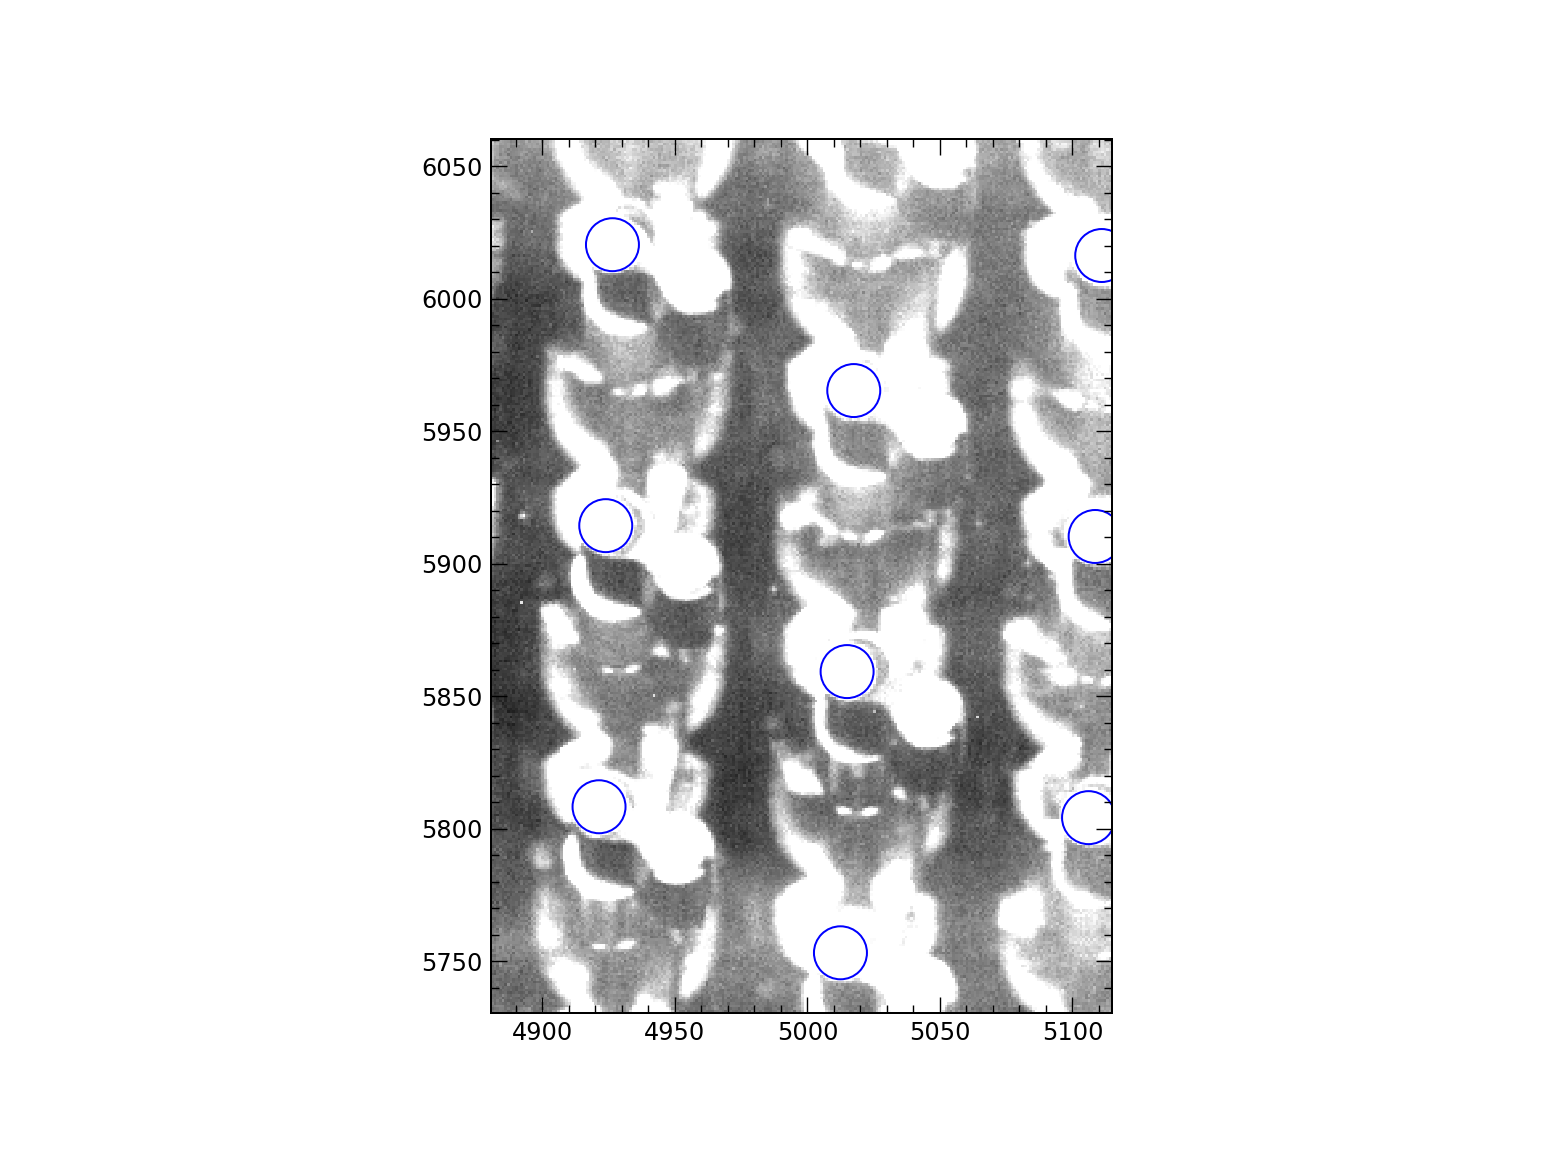

In [30]:

#m, s = np.mean(data), np.std(data)
m, s = 300, 100

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
#im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

#for x,y,r in zip(df['x_meas'], df['y_meas'], df['r_meas']):
#    c1 = plt.Circle((x,y), r, color='red', fill=False)
#    ax.add_artist(c1)
#for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
#    c2 = plt.Circle((x,y), r, color='blue', fill=False)
#    ax.add_artist(c2)
for x,y,r in zip(df['x_dot'], df['y_dot'], df['r_dot']):
    c2 = plt.Circle((x,y), r, color='blue', fill=False)
    ax.add_artist(c2)

plt.show()

## save as region file

In [32]:
filename = 'tmp_20200710.reg'
with open(filename, 'w') as f:
    f.write('# Region file format: DS9 version 4.1\n')
    f.write('global color=green dashlist=8 3 width=3 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    f.write('image\n')
    for x, y, r in zip(df['x_dot'], df['y_dot'], df['r_dot']):
        f.write('circle(%.2f,%.2f,%.2f)\n' % (x+1, y+1, r))   